## Домашнє завдання: Алгоритми бустингу

В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

#### Необхідні імпорти

In [1]:
!pip install hyperop

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Any

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from pprint import pprint
from datetime import datetime

import lightgbm as lgb

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
file_name = '/content/drive/MyDrive/ML/data/bccp/train.csv'

In [6]:
raw_train_data = pd.read_csv(file_name)
raw_train_data.head(3)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.0,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.0,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.0,3.0,0.0,0.0,179655.87,1.0


In [7]:
def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [8]:
target_col = 'Exited'
train_df, val_df = split_train_val(df=raw_train_data, target_col=target_col)

unnecessary_columns=[ 'id', 'Exited'] #'Surname',	'CustomerId']
input_cols = [col for col in raw_train_data.columns if col not in unnecessary_columns]

X_train, y_train = separate_inputs_targets(df=train_df,input_cols=input_cols, target_col=target_col)
X_val, y_val = separate_inputs_targets(df=val_df,input_cols=input_cols, target_col=target_col)

#### Завдання 1

1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [9]:
cat_col_names = X_train.select_dtypes('object').columns.tolist()

In [10]:
X_train[cat_col_names] = X_train[cat_col_names].apply(pd.Categorical)
X_val[cat_col_names] = X_val[cat_col_names].apply(pd.Categorical)

In [11]:
X_train.head(3)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
7180,15652218.0,Mays,682.0,France,Male,30.0,1.0,131394.56,1.0,1.0,1.0,143952.24
10393,15592937.0,Ch'eng,684.0,France,Female,39.0,2.0,178058.06,1.0,1.0,0.0,145518.31
80,15774586.0,Ch'in,705.0,Germany,Male,35.0,6.0,116320.68,2.0,1.0,0.0,174431.01


#### Завдання 2

2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [12]:
xgb_clf = XGBClassifier(
    n_estimators=10,
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=1,
    enable_categorical=True,
    device='cuda'
)

xgb_clf.fit(X_train, y_train)

train_probs = xgb_clf.predict_proba(X_train)[:, 1]
val_probs = xgb_clf.predict_proba(X_val)[:, 1]

train_auc = roc_auc_score(y_train, train_probs)
val_auc = roc_auc_score(y_val, val_probs)

print(f"Train ROC-AUC: {train_auc:.4f}; Validation ROC-AUC: {val_auc:.4f}")

Train ROC-AUC: 0.9107; Validation ROC-AUC: 0.9038


**Спостереження**:

- Загалом якість моделі достатньо висока, значення метрики ROC-AUC не сильно відрізняється для тренувального та валідацційного наборів даних, отже модель гарно генералізує.

- Модель гарно навчилася на тренувальних даних та має подібний всокий скор на валідаційних даних, отже можемо сказати high bias/high variance - відсутні.

- Порівнюючи з зі найпростішою моделлю DecisionTrees - ця модель набагато краща.

- Порівнюючи з моделлю DecisionTrees натреноваю з гіперпараметром `max_depth=5` (Train:0.9257/Validation:0.9219), то XGBoost показала трішки гірші результати.

#### Завадання 3

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [13]:
def objective(params, model_class, **model_kwargs):
    model = model_class(
        **{k: int(v) if k in ['n_estimators', 'max_depth', 'min_child_weight', 'num_leaves'] else v for k, v in params.items()}, **model_kwargs
    )

    if model_class == lgb.LGBMClassifier:
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], categorical_feature=model_kwargs.get('categorical_feature', []))
    else:
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    val_pred = model.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, val_pred)

    return {'loss': -roc_auc, 'status': STATUS_OK}


In [14]:
xgb_space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.1, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

In [15]:
xgb_trials = Trials()
xgb_best = fmin(
    fn=lambda params: objective(params, XGBClassifier, enable_categorical=True, use_label_encoder=False, random_state=42, device='cuda'),
    space=xgb_space, algo=tpe.suggest, max_evals=20, trials=xgb_trials
)

100%|██████████| 20/20 [00:24<00:00,  1.21s/trial, best loss: -0.9361993278002606]


In [16]:
xgb_best['n_estimators'] = int(xgb_best['n_estimators'])
xgb_best['max_depth'] = int(xgb_best['max_depth'])
xgb_best['min_child_weight'] = int(xgb_best['min_child_weight'])

print("Найкращі гіперпараметри: ")
pprint(xgb_best)

Найкращі гіперпараметри: 
{'colsample_bytree': 0.6262348127762706,
 'gamma': 0.005077706296407025,
 'learning_rate': 0.026113552430464787,
 'max_depth': 8,
 'min_child_weight': 7,
 'n_estimators': 125,
 'reg_alpha': 0.2087933489981597,
 'reg_lambda': 0.9007418874425132,
 'subsample': 0.3937056174052659}


In [17]:
final_clf = XGBClassifier(
    n_estimators=xgb_best['n_estimators'],
    learning_rate=xgb_best['learning_rate'],
    max_depth=xgb_best['max_depth'],
    min_child_weight=xgb_best['min_child_weight'],
    gamma=xgb_best['gamma'],
    subsample=xgb_best['subsample'],
    colsample_bytree=xgb_best['colsample_bytree'],
    reg_lambda=xgb_best['reg_lambda'],
    reg_alpha=xgb_best['reg_alpha'],
    enable_categorical=True,
    random_state=42,
    device='cuda'
).fit(X_train, y_train)

train_pred = final_clf.predict_proba(X_train)[:, 1]
val_pred = final_clf.predict_proba(X_val)[:, 1]

train_auc = roc_auc_score(y_train, train_pred)
val_auc = roc_auc_score(y_val, val_pred)

print(f"Train ROC-AUC: {train_auc:.4f}; Validation ROC-AUC: {val_auc:.4f}")

Train ROC-AUC: 0.9497; Validation ROC-AUC: 0.9362


**Спостереження**:

- Якість моделі достатньо висока, значення метрики ROC-AUC не сильно відрізняється для тренувального та валідацційного наборів даних, отже модель покахує гарну спроможність узагальнювати.

- Якість моделі зросла порівняно з минулою моделлю, отже якість підвищилась.

- Порівнючи з найкращим результатом, отриманим з моделлю DecisionTrees(натреноваю з гіперпараметром `max_depth=5` де Train:0.9257/Validation:0.9219) - отрмана модель XGBoostClassifier  з затюненими параметрами краща.

- Модель гарно навчилася на тренувальних даних та має подібний всокий скор на валідаційних даних, отже можемо сказати high bias/high variance - відсутні.

#### Завадння 4

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [18]:
X_train.head(3)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
7180,15652218.0,Mays,682.0,France,Male,30.0,1.0,131394.56,1.0,1.0,1.0,143952.24
10393,15592937.0,Ch'eng,684.0,France,Female,39.0,2.0,178058.06,1.0,1.0,0.0,145518.31
80,15774586.0,Ch'in,705.0,Germany,Male,35.0,6.0,116320.68,2.0,1.0,0.0,174431.01


In [19]:
cat_feature_indexes = [X_train.columns.get_loc(col) for col in cat_col_names]
cat_feature_indexes

[1, 3, 4]

In [ ]:
lgb_clf = lgb.LGBMClassifier(
    max_depth=3,
    n_estimators=50,
    learning_rate=0.1,
    cat_feature=cat_feature_indexes,
    missing=np.nan,
    # device='cuda'
)

lgb_clf.fit(X_train, y_train, eval_set=[(X_val, y_val)])

train_probs = lgb_clf.predict_proba(X_train)[:, 1]
val_probs = lgb_clf.predict_proba(X_val)[:, 1]

train_auc = roc_auc_score(y_train, train_probs)
val_auc = roc_auc_score(y_val, val_probs)

In [22]:
print(f"Train ROC-AUC: {train_auc:.4f}; Validation ROC-AUC: {val_auc:.4f}")

Train ROC-AUC: 0.9505; Validation ROC-AUC: 0.9351


**Спостереження**:

- Модель показує високу якість класифікації як на тренувальному, так і на валідаційному наборах (де значення ROC-AUC на тренувальних даних 0.9505 а на валідаціни 0.9351).

- Висока якість на тренувальних і валідаційних даних із невеликим розривом між ними свідчить про хороший баланс між bias і variance.

- Моделі притаманний скоріше high variance, оскільки присутній невеликий розрив між Train і Validation ROC-AUC, але він не є великим, отже не можемо стверджувати про явне перенавчання.

- Ознаки high bias не спостерігаються оскільки модель має високу якість.

- LightGBM має трохи вище значення ROC-AUC на тренувальному датасеті, але трошки нижче значення метрики на валідаційному наборі.Модемо сказати про приблизно однакову якість моделі, але XGBoost має кращі ущагальнувальні якості.

#### Завдання 5

5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [23]:
lgb_space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)
}

In [ ]:
lgb_trials = Trials()
lgb_best = fmin(
    fn=lambda params: objective(params, lgb.LGBMClassifier, cat_feature=cat_feature_indexes),
    space=lgb_space, algo=tpe.suggest, max_evals=10, trials=lgb_trials
)

In [25]:
lgb_best['n_estimators'] = int(lgb_best['n_estimators'])
lgb_best['max_depth'] = int(lgb_best['max_depth'])
lgb_best['num_leaves'] = int(lgb_best['num_leaves'])
lgb_best['min_child_weight'] = int(lgb_best['min_child_weight'])

print("Найкращі гіперпараметри: ")
pprint(lgb_best)

Найкращі гіперпараметри: 
{'colsample_bytree': 0.7205651640632382,
 'learning_rate': 0.027066160242272014,
 'max_depth': 12,
 'min_child_weight': 9,
 'min_split_gain': 0.04213135674682016,
 'n_estimators': 400,
 'num_leaves': 128,
 'reg_alpha': 0.0016556349510271628,
 'reg_lambda': 0.0822969976122947,
 'subsample': 0.9472772275673371}


In [ ]:
final_lgb = lgb.LGBMClassifier(
    n_estimators=lgb_best['n_estimators'],
    learning_rate=lgb_best['learning_rate'],
    max_depth=lgb_best['max_depth'],
    num_leaves=lgb_best['num_leaves'],
    min_child_weight=lgb_best['min_child_weight'],
    subsample=lgb_best['subsample'],
    colsample_bytree=lgb_best['colsample_bytree'],
    reg_alpha=lgb_best['reg_alpha'],
    reg_lambda=lgb_best['reg_lambda'],
    min_split_gain=lgb_best['min_split_gain'],
    cat_feature=cat_feature_indexes
).fit(X_train, y_train)

In [30]:
train_pred = final_lgb.predict_proba(X_train)[:, 1]
val_pred = final_lgb.predict_proba(X_val)[:, 1]

train_auc = roc_auc_score(y_train, train_pred)
val_auc = roc_auc_score(y_val, val_pred)

print(f"Train ROC-AUC: {train_auc:.4f}; Validation ROC-AUC: {val_auc:.4f}")

Train ROC-AUC: 0.9962; Validation ROC-AUC: 0.9333


**Спостереження**:

- Модель показує вище значення метрики ROC-AUC: на тренувальих даних, так нижче на валідаційних. Отже модель стала гріше генералізувати;

- Розрив між значення ROC-AUC на тренувальних та валідацівйних данних  збільшився, що вказує на зростання high variance;

- Можемо сказати, що модель стала більш складною, що збільшило її здатність запам’ятовувати тренувальні дані, але трохи знизило узагальнюючу здатність.

#### Завдання 6

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

**Обрана модель**

Для сабмішину обрана модель - XGBClassifier з оптимізацією гіперпарамтерів, адже модель має високе значення ROC-AUC на валідаційних даних, та має меший розрив між валідаційними та тренувальними даними, тобто модель менш схильна до перенавчання.

In [28]:
model = final_clf
file_name = '/content/drive/MyDrive/ML/data/bccp/sample_submission.csv'
sample = pd.read_csv(file_name)

file_name = '/content/drive/MyDrive/ML/data/bccp/test.csv'
test_df = pd.read_csv(file_name)

inputs = test_df[input_cols].copy()
inputs[cat_col_names] = inputs[cat_col_names].apply(pd.Categorical)
preds = model.predict_proba(inputs)[:,1]

test_df['Exited'] = preds
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
sub_path = 'drive/My Drive/ML/data/bccp/lab/submission'

upd_sample = sample.copy()
upd_sample['Exited'] = upd_sample['id'].map(test_df.set_index('id')['Exited'])
upd_sample.to_csv(f'{sub_path}/submission_{timestamp}.csv', index=False)

Скор к змаганні отриманий для за допомогою моделі XGBClassifier

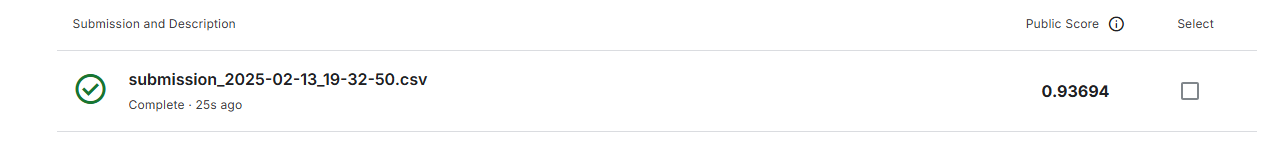

Скор к змаганні отриманий для за допомогою моделі LGBMClassifier

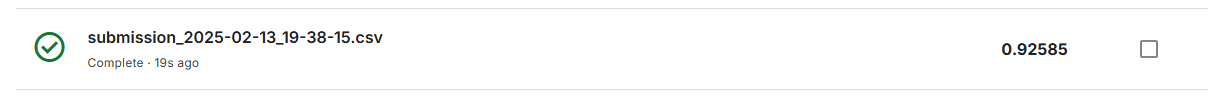